#### Brian Ramirez

# Sentiment Analysis using Neural Networks

## Research Question

<p>Can a neural network model be trained to determine whether the sentiment of a user review is positive or negative?</p>

## Objectives and Goals

The goals of the analysis are as follows:
<ul>
    <li>Create a neural network model trained on user review data</li>
    <li>Use the model to interpret the sentiment of user reviews</li>
</ul>

## Type of Neural Network to be Used

<p>Recurrent Neural Network (RNN) is a neural network that can be used to make predictions on text sequences. According to <em>Toward Data Science</em>, RNNs are useful for "tasks that involve sequential inputs, such as speech and language" (Nabi, 2019). RNN will be used since the goal of the analysis involves speech and language in the form of user reviews.</p>

## Data Preparation

<strong>Import Packages and Libraries</strong>

In [58]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import re
import contractions
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import datetime
import emot
import pickle
from emot.emo_unicode import EMOTICONS_EMO
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os
import warnings
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

<strong>Import and Concatenate the Data Sets</strong>

In [2]:
amzn = pd.read_csv('amazon_cells_labelled.txt', sep = '\t', header = None, names = ['review', 'rating'])
amzn['source'] = 'amazon'

imdb = pd.read_csv('imdb_labelled.txt', sep = ' \t', header = None, names = ['review', 'rating'])
imdb['source'] = 'imdb'

yelp = pd.read_csv('imdb_labelled.txt', sep = ' \t', header = None, names = ['review', 'rating'])
yelp['source'] = 'yelp'

df = pd.concat([amzn, imdb, yelp], ignore_index = True)
pd.set_option('display.max_colwidth', 5000)

<strong>Inspect the Data</strong>
<p>Each of the original three data sets contained 1,000 rows, resulting in a combined data set of 3,000 rows.</p>

In [3]:
print('  IMDB Data shape: {}\n  Yelp Data shape: {}\nAmazon Data shape: {}\nConcat Data shape: {}'.format(imdb.shape, yelp.shape, amzn.shape, df.shape))

  IMDB Data shape: (1000, 3)
  Yelp Data shape: (1000, 3)
Amazon Data shape: (1000, 3)
Concat Data shape: (3000, 3)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3000 non-null   object
 1   rating  3000 non-null   int64 
 2   source  3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB


In [5]:
df.head()

,review,rating,source
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,amazon
4,The mic is great.,1,amazon


In [6]:
print('Rating Count:\n{}'.format(df['rating'].value_counts()))

Rating Count:
0    1500
1    1500
Name: rating, dtype: int64


<Axes: title={'center': 'Rating Count'}>

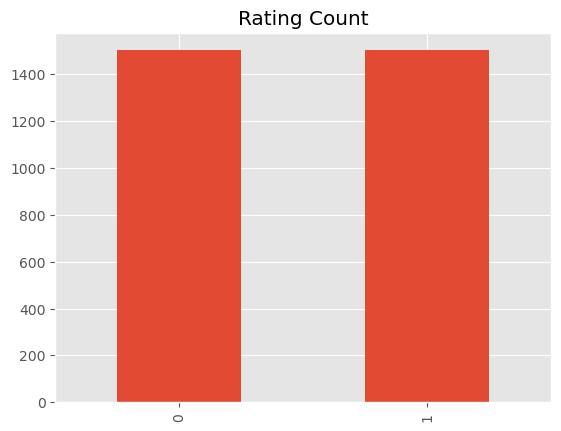

In [7]:
df['rating'].value_counts().sort_index().plot(kind = 'bar', title = 'Rating Count')

<strong>Check for Missing, NA, or Duplicate Values</strong>

In [8]:
df.isnull().any()

review    False
rating    False
source    False
dtype: bool

In [9]:
df.isna().any()

review    False
rating    False
source    False
dtype: bool

In [10]:
df.duplicated().any()

True

In [11]:
df.duplicated().sum()

16

In [12]:
df.dropna()

,review,rating,source
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
2995,I just got bored watching Jessice Lange take her clothes off!,0,yelp
2996,"Unfortunately, any virtue in this film's production work was lost on a regrettable script.",0,yelp
2997,"In a word, it is embarrassing.",0,yelp
2998,Exceptionally bad!,0,yelp


In [13]:
dup_df = df[df.duplicated(keep = False)]

df = df.drop_duplicates()
df = df.reset_index()
df = df.drop('index', axis = 1)
df.duplicated().any()

False

<strong>Data Treatment Results</strong>

In [14]:
print('Data shape after treatment:\n{}'.format(df.shape))
print('\nRating count after treatment:\n{}'.format(df['rating'].value_counts()))
df.head()

Data shape after treatment:
(2984, 3)

Rating count after treatment:
0    1495
1    1489
Name: rating, dtype: int64


,review,rating,source
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,amazon
4,The mic is great.,1,amazon


<strong>Collect Length and Word Count</strong>

In [15]:
df['review_length'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()

In [16]:
df.head()

,review,rating,source,review_length,word_count
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,amazon,82,21
1,"Good case, Excellent value.",1,amazon,27,4
2,Great for the jawbone.,1,amazon,22,4
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,amazon,79,11
4,The mic is great.,1,amazon,17,4


<strong>Create a List of Unique Characters</strong>

<p>A list of distinct characters within the data set.</p>

In [17]:
commentary = df['review']
list_of_characters = []
for comment in commentary:
    for character in comment:
        if character not in list_of_characters:
            list_of_characters.append(character)

<strong>Create a List of Unusual Characters</strong>

<p>A list of non-alphanumeric characters.</p>

In [18]:
chars = []
for character in list_of_characters:
    if character not in chars:
        chars.append(re.search('[^a-zA-Z0-9s]', character))
        
unusual_chars = []
for char in chars:
    if char != None:
        unusual_chars.append(char)

<strong>Check for Emojis</strong>

In [19]:
emoticon_df = df[df['review'].str.contains(r'(?:[:;]\S?[\)\(])')]
emoji_rev_cnt = (len(emoticon_df))

<strong>Vectorize</strong>

In [20]:
vectorizer = CountVectorizer()

matrix = vectorizer.fit_transform(df.review)
counts = pd.DataFrame(matrix.toarray(), columns = vectorizer.get_feature_names())

<strong>Make a Copy</strong>

In [21]:
clean_df = df.copy()

<strong>Convert Text to Lowercase</strong>

In [22]:
clean_df['review'] = clean_df['review'].str.lower()

<strong>Remove Contractions</strong>

In [23]:
def contraction_replace(text):
    return contractions.fix(text)
clean_df["review"] = clean_df["review"].apply(lambda x: contraction_replace(x))

<strong>Replace Emoticons</strong><br>
Emoticons should be converted into text before removing non-letter characters. According to <em>Geek Culture,</em> removing emoticons completely will "lose valuable information", so the emoticons should be converted to "preserve the emoji information" (Mahto, 2021). The smiley face and sad face emojis will be replaced with the words "smile" and "sad" to preserve the sentiment.

In [24]:
def convert_smile(text):
    smile_convert = re.sub(r"(?:(\:\))|(\:-\)|(\;\))))", " smile ", text)  
    return smile_convert

clean_df["review"] = clean_df["review"].apply(lambda x: convert_smile(x))

In [25]:
def convert_sad(text):
    sad_convert = re.sub(r"(?:(\:\())", " sad ", text)    
    return sad_convert

clean_df["review"] = clean_df["review"].apply(lambda x: convert_sad(x))

<strong>Remove Punctuation, Numbers, and Whitespace</strong>

In [26]:
clean_df['review'] = clean_df['review'].apply(lambda x: re.sub(r'[^a-z\s]+', " ", x))
clean_df['review'] = clean_df['review'].apply(lambda x: re.sub(r'[\x85]+', " ", x))
clean_df['review'] = clean_df['review'].str.replace('\d', '', regex = True)
clean_df['review'] = clean_df['review'].str.strip()

<strong>Remove Stopwords and Lemmatize</strong>

In [27]:
review_list = []
review_length = []

stop_words = stopwords.words('english')

for review in clean_df.review:
    review = re.sub("[^a-zA-Z\s]", "", review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    review = [word for word in review if not word in stop_words]
    lemma = nltk.WordNetLemmatizer()
    review = [lemma.lemmatize(word) for word in review]
    rev_len = len(review)
    review_length.append(rev_len)
    review_list.append(review)

review_list = np.asarray(review_list, dtype = object)

In [28]:
clean_commentary = clean_df['review']
clean_list_of_characters = []
for comment in clean_commentary:
    for character in comment:
        if character not in clean_list_of_characters:
            clean_list_of_characters.append(character)

<strong>Remove Duplicate Words</strong>

In [29]:
# Reference: StackOverflow
#            Python DataFrame: Remove Duplicate Words in the Same Cell within a Column in Python

clean_df['review'] = (clean_df['review'].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))

<strong>Remove Words with a Single Occurrence</strong>

In [30]:
def infreq(text):
    freq = pd.Series(' '.join(clean_df['review']).split()).value_counts()
    less_freq = list(freq[freq ==1].index)
    words = [word for word in text.split() if word not in less_freq]
    new_text = " ".join(words)
    return new_text

clean_df['review'] = clean_df['review'].apply(lambda x: infreq(x))      

In [31]:
clean_df = clean_df.drop(columns = ['review_length', 'word_count'], axis = 1)
clean_df["review_length"] = clean_df['review'].str.len()
clean_df["word_count"] = clean_df["review"].str.split().str.len()

<strong>Vectorize</strong>

In [32]:
vectorizer = CountVectorizer()
clean_matrix = vectorizer.fit_transform(clean_df.review)
clean_counts = pd.DataFrame(clean_matrix.toarray(), columns = vectorizer.get_feature_names())

<strong>Tokenize and Pad</strong>

In [33]:
words_count = len(clean_counts.columns)

review = clean_df.review.values
tokenizer = Tokenizer(num_words = words_count)
tokenizer.fit_on_texts(review)

vocab_size = (len(tokenizer.word_index) + 1)
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
encoded_docs = tokenizer.texts_to_sequences(review)
max_length = clean_df.word_count.max()
padded_sequence = pad_sequences(encoded_docs, max_length, padding = 'pre', truncating = 'pre')

<strong>Split into Training and Test Sets</strong>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequence, np.array(df.rating), test_size = 0.2, random_state = 42)

## Data Cleaning Summary

<strong>Unique Characters Before Data Cleaning</strong><br>
<p>The original dataset contained duplicate characters, non-alphanumeric characters, and punctuation marks.</p>

In [35]:
print('Unique character count: {}\n{}'.format(len(list_of_characters), list_of_characters))

Unique character count: 88
['S', 'o', ' ', 't', 'h', 'e', 'r', 'i', 's', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'U', 'I', 'b', 'c', 'v', '.', 'G', 'd', ',', 'E', 'x', 'j', 'T', '4', '5', 'M', 'A', 'J', 'O', 'R', 'P', 'B', 'L', '!', 'z', 'N', 'W', 'q', 'H', '+', 'V', '"', 'Y', 'D', 'F', 'k', "'", 'K', 'C', '/', '7', '3', '6', '8', '0', '2', '?', 'Z', '-', '1', ':', ')', '(', 'Q', '&', '$', '*', ';', 'X', '%', '9', '#', '[', ']', '\x96', 'é', '\x85', 'å', '\x97']


<strong>Non alpha-numeric characters</strong><br>
<p>The original dataset contains the following non alpha-numeric characters:</p>

In [37]:
print('Non alpha-numeric character count: {}'.format(len(unusual_chars)))        
for i in unusual_chars:
    print(i)

Non alpha-numeric character count: 26
<re.Match object; span=(0, 1), match=' '>
<re.Match object; span=(0, 1), match='.'>
<re.Match object; span=(0, 1), match=','>
<re.Match object; span=(0, 1), match='!'>
<re.Match object; span=(0, 1), match='+'>
<re.Match object; span=(0, 1), match='"'>
<re.Match object; span=(0, 1), match="'">
<re.Match object; span=(0, 1), match='/'>
<re.Match object; span=(0, 1), match='?'>
<re.Match object; span=(0, 1), match='-'>
<re.Match object; span=(0, 1), match=':'>
<re.Match object; span=(0, 1), match=')'>
<re.Match object; span=(0, 1), match='('>
<re.Match object; span=(0, 1), match='&'>
<re.Match object; span=(0, 1), match='$'>
<re.Match object; span=(0, 1), match='*'>
<re.Match object; span=(0, 1), match=';'>
<re.Match object; span=(0, 1), match='%'>
<re.Match object; span=(0, 1), match='#'>
<re.Match object; span=(0, 1), match='['>
<re.Match object; span=(0, 1), match=']'>
<re.Match object; span=(0, 1), match='\x96'>
<re.Match object; span=(0, 1), matc

<p>Non-alphanumeric characters were removed from the clean data set.</p>

<strong>Unique Characters After Data Cleaning</strong>

Converting the text to lower case and removing non-alphanumeric characters and punctuation marks resulted in the following unique characters:

In [36]:
print('Clean character count: {}\n{}'.format(len(clean_list_of_characters), clean_list_of_characters))

Clean character count: 27
['s', 'o', ' ', 't', 'h', 'e', 'r', 'i', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'b', 'c', 'v', 'd', 'x', 'j', 'z', 'q', 'k']


<strong>Emojis</strong><br>
<p>The original data set contains the following emoticons:</p>

In [38]:
print('Reviews with Emojis: {}'.format(emoji_rev_cnt))
emoticon_df

Reviews with Emojis: 8


,review,rating,source,review_length,word_count
386,The best phone in market :).,1,amazon,28,6
967,":-)Oh, the charger seems to work fine.",1,amazon,38,7
1366,"I really loved the story line and the poler bear was kinda cute.But if anyone has a question about Fort Steele, just ask away:)",1,imdb,128,24
1973,;) Recommend with confidence!,1,imdb,30,4
1976,":) Anyway, the plot flowed smoothly and the male-bonding scenes were a hoot.",1,imdb,77,13
2363,"I really loved the story line and the poler bear was kinda cute.But if anyone has a question about Fort Steele, just ask away:)",1,yelp,128,24
2970,;) Recommend with confidence!,1,yelp,30,4
2973,":) Anyway, the plot flowed smoothly and the male-bonding scenes were a hoot.",1,yelp,77,13


<p>The emoticons were replaced with text values in the cleaned data set:</p>

In [39]:
print('Original: \n{}'.format(emoticon_df['review'].iloc[0]))
print('\nEmoticon Replaced:\n{}'.format(clean_df['review'].iloc[386]))

Original: 
The best phone in market :).

Emoticon Replaced:
the best phone in market smile


### Vocabulary Size

In [40]:
print('Vocab Size: {}'.format(vocab_size))

Vocab Size: 3281


###  Proposed Word Embedding Length

In [42]:
print('Word Embedding Length: {}'.format(max_sequence_embedding))

Word Embedding Length: 8


### Statistical Justification for the Chosen Maximum Sequence Length
<p>The maximum sequence length is set to the amount of words in the review with the most words.<br>The equation can be seen above in the section titled <em>Collect length and word count.</em><br>
The result of the equation is listed below:</p>

In [43]:
print('Maximum sequence length: {}'.format(max_length))

Maximum sequence length: 57


### Goals of the Tokenization Process

<p>The tokenization process and code generation is shown above in the section titled <em>Tokenization.</em><br>
The goal of tokenization is to convert each word into a numeric value that can be understood by the computer during the analysis.</p>
    <p>Keras includes a package called <em>Tokenizer</em> to tokenize the data.<br>
    The package can be seen in the <em>imports</em> section above as:<br> <em>from tensorflow.keras.preprocessing.text import Tokenizer</em>.</p>

### Padding Process

<p>The Keras library includes a method called "pad_sequence". The method import can be seen in the <em>imports</em> section above as:<br> <em>from tensorflow.keras.preprocessing.sequence import pad_sequences.</em><br>The method takes in a parameter for the maximum sequence length, then pads each sequence with 0s to meet that length. The maximum length should be set to the length of the longest sequence in the data set.</p>

<p>The <em>pad_sequence</em> method allows padding to be added to the beginning or end of the text sequence. <br>
The padding will be added at the beginning of each sequence for this analysis.</p>


In [44]:
print('Padded Sequence: {}'.format(padded_sequence[0]))   

Padded Sequence: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  29  38   2  57 104  16  79   9 358   5  11 143   1 332 838   6
 152  50   4]


###  Categories of Sentiment and Activation Function

<p>The data set has a numeric column named "rating" which refers to the sentiment. <br>The each row in the column contains either a 0 or a 1. A 0 value is a negative sentiment, while a 1 value is a positive sentiment.<br>
Two categories of sentiment will be included to match the data set.</p>
<p>The chosen activation function is the Sigmoid Function.<br>
The Sigmoid Function returns a binary value of either 0 or 1, which matches up with the binary values in the rating column.</p>

### Data Preparation Steps

<p>Preparation of the data included the following steps:</p>
<ul>
    <li>Load the three CSV files into their own data frames.</li>
    <li>Concatenate the three data frames into one.</li>
    <li>Explore the data set.</li>
    <li>Treat any null, duplicate, or na values.</li>
    <li>Check for unusual characters.</li>
    <li>Check for emojis.</li>
    <li>Change the review column to all lowercase.</li>
    <li>Remove punctuation.</li>
    <li>Remove stopwords and lemmatize.</li>
    <li>Tokenize.</li>
    <li>Pad the sequences to equal lengths.</li>
</ul>

<p>The data was then split into an 80% training set and a 20% test set.<br>
The results of the split can be seen below:</p>

In [45]:
print('Training Shape:\n {} , {}\nTest Shape:\n {} , {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Training Shape:
 (2387, 57) , (2387,)
Test Shape:
 (597, 57) , (597,)


### Clean Copy of the Data Set

In [46]:
# Training set copy
pd.DataFrame(X_train).to_csv('X_train.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')

# Test set copy
pd.DataFrame(X_test).to_csv('X_test.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

# Clean DataFrame copy
clean_df.to_csv('clean_df.csv')

## Network Architecture

### Output of the Model Summary from TensorFlow

In [50]:
print(vocab_size)
print(max_sequence_embedding)
print(max_length)

3281
8
57


In [52]:
keras.backend.clear_session()
num_epochs = 25
early_stop = EarlyStopping(monitor = 'val_loss', patience =  3)

model = keras.Sequential([
   keras.layers.Embedding(vocab_size, max_sequence_embedding, input_length = max_length)
    ,keras.layers.GlobalAveragePooling1D()
    ,keras.layers.Dense(50, activation="relu")
    ,keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss = 'BinaryCrossentropy'
              ,optimizer = 'adam'
              ,metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 57, 8)             26248     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 50)                450       
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 26,749
Trainable params: 26,749
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs = num_epochs, batch_size = 32, callbacks = [early_stop])

loss, accuracy = model.evaluate(X_test, y_test, verbose = False)

print('\n    Test Loss: {}\nTest Accuracy: {}'.format(loss, accuracy))

Epoch 1/25
75/75 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.5233 - val_loss: 0.6920 - val_accuracy: 0.4824
Epoch 2/25
75/75 [==============================] - 0s 2ms/step - loss: 0.6866 - accuracy: 0.5568 - val_loss: 0.6809 - val_accuracy: 0.8023
Epoch 3/25
75/75 [==============================] - 0s 2ms/step - loss: 0.6611 - accuracy: 0.8027 - val_loss: 0.6471 - val_accuracy: 0.8258
Epoch 4/25
75/75 [==============================] - 0s 2ms/step - loss: 0.5955 - accuracy: 0.8643 - val_loss: 0.5823 - val_accuracy: 0.8141
Epoch 5/25
75/75 [==============================] - 0s 2ms/step - loss: 0.4996 - accuracy: 0.8827 - val_loss: 0.5040 - val_accuracy: 0.8442
Epoch 6/25
75/75 [==============================] - 0s 2ms/step - loss: 0.4027 - accuracy: 0.9041 - val_loss: 0.4379 - val_accuracy: 0.8576
Epoch 7/25
75/75 [==============================] - 0s 2ms/step - loss: 0.3266 - accuracy: 0.9191 - val_loss: 0.3898 - val_accuracy: 0.8727
Epoch 8/25
75/75 [==

### Layers and Parameters

<p>The model includes four layers. The layer types and parameters are as follows:</p>

<ol>
    <li>Embedding:<br>Acts as the input layer. The embedding layer in this case takes 26,248 parameters.</li>
    <li>GlobalAveragePooling1D():<br>Takes no parameters. Flattens the first layer.</li>
    <li>Dense:<br>Takes 450 parameters. Uses the "ReLU" activation method.</li>
    <li>Output:<br>The loss function was set to <em>BinaryCrossentropy</em>, which is binary. The binary pattern only requires one node.</li>
</ol>

## Hyperparameters

### Activation Functions

<strong>Rectified Linear Activation (RELU)</strong>
<p>The chosen activation function is ReLU. According to <em>Machine Learning Mastery</em>, ReLU is "the default function for many neural networks" because it is "easier to train and often achieves better performance" (Brownlee, 2020). ReLU was chosen for its performance and ease-of-use.</p><br>

<strong>Sigmoid</strong><br>
<p>The Sigmoid function works well on binary values. It was chosen because the rating column contains binary values of either 0 or 1.</p>

### Nodes per Layer

<ul>
    <li>
        <strong>Embedding Layer</strong>
        <p>The embedding layer contains 57 nodes to match the maximum word length.</p><br>
    </li>
    <li>
        <strong>Flatten Layer</strong>
        <p>The flatten layer does not contain any nodes.</p><br>
    </li>
    <li>
        <strong>Dense Layer</strong>
        <p>The dense layer contains 50 nodes. Various node counts were attempted with 50 being the most accurate choice.</p><br>
    </li>
    <li>
        <strong>Activation Layer</strong>
        <p>The activation, or output layer, contains one node referring to the binary cross entropy.</p><br>
    </li>
</ul>

### Loss Function

<strong>Binary Cross Entropy</strong><br>
Binary Cross Entropy is used for binary classification.<br>
The ratings column contained binary values of either 0 or 1, which is why the function was selected.<br>

### Optimizer

<strong>Adam Optimizer</strong><br>
The Adam Optimizer is the default choice for neural network models. According to <em>Spot Intelligence</em>, Adam has a "faster convergence and better performance than other optimization algorithms" and is also "easier and more robust" (Van Otten, 2023). Adam was chosen because of its high performance and usability. <br>

### Stopping Criteria

<strong>Validation Loss</strong><br>
Validation Loss was chosen as the stopping criteria with a patience level of three. The criteria was chosen to prevent overfitting. <em>Training Validation Loss in Deep Learning</em> states that overfitting occurs when the model "cannot generalize on new data" and claims overfitting can be prevented by halting when the validation loss is "low and stable" (Baeldung, 2023). A model can sometimes increase in performance after a short trend of loss. The criteria is set to halt three epochs after an upward trend of loss to ensure the loss is stable.


### Evaluation Metric

<strong>Accuracy</strong><br>
The chosen evaluation metric was accuracy. The business question asks whether a model can be trained to predict the sentiment of reviews. The best way to evaluate the predictions is to base the evaluation on the prediction accuracy.<br>
The evaluation can be seen below:

In [54]:
print('\n    Test Loss: {}\nTest Accuracy: {}'.format(loss, accuracy))


    Test Loss: 0.2803545892238617
Test Accuracy: 0.8961474299430847


# Model Evaluation

### Impact of  Stopping Criteria

<p>Early Stopping is a method used to prevent overfitting. Using early stopping instead of defining the number of epochs might prevent overfitting, but it may not lead to the best performing model. To ensure the best performing model is still captured, a patience level of three was set. The model will continue with three epochs after an upward trend of loss to ensure to further gains can be made and that the loss is stable.</p>
<p>The best training epoch can be seen in the model above at Epoch 17. The stopping criteria continued for three more epochs, making the final epoch number 20.</p>

### Visualization of the Model Training Process

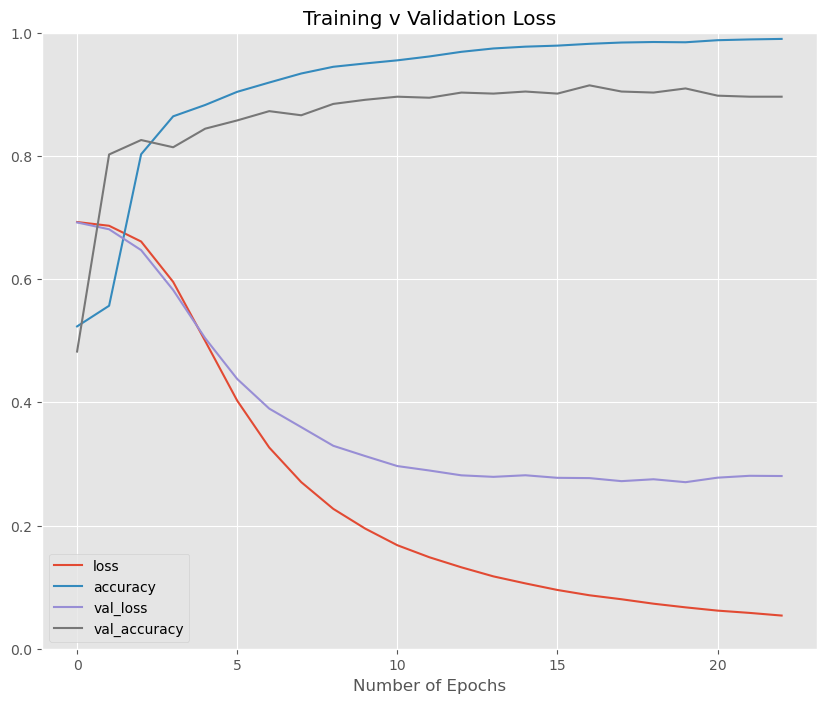

In [55]:
# Line Graph of Loss

pd.DataFrame(history.history).plot(figsize = (10, 8))
plt.gca().set_ylim(0, 1)
plt.xlabel('Number of Epochs')
plt.legend()
plt.title('Training v Validation Loss')
plt.show()

### Fitness of the Model and Measures Taken to Address Overfitting

<p>The model appears to be fit and does not show signs of overfitting. <br>Validation data was used in conjunction with early stopping to prevent overfitting. The model was set to halt three epochs after an upward trend of validation loss. The measures ensure model fitness and performance.</p>

### Predictive Accuracy of the Trained Network

<p>The model was created to predict the sentiment of user reviews. The training data included a binary rating with 0 being a negative rating and 1 being positive. <br>
    The predictive accuracy of the trained network can be seen below.</p>

In [56]:
print('\n    Test Loss: {:.3%}\nTest Accuracy: {:.3%}'.format(loss, accuracy))


    Test Loss: 28.035%
Test Accuracy: 89.615%


## Summary and Recommendations

In [57]:
model.save('D213_Task2_garyramirez.h5')

### Functionality of the Neural Network and Impact of the Network Architecture

<p>The model was trained with a clean data set of 2,984 user reviews. The number of sentiments were balanced with 1,495 negative and 1,489 positive after cleaning.</p>

<p>Evaluation metrics suggest the model can predict review sentiments with a predictive accuracy of 89.615%.</p>

<p>Recurrent Neural Network (RNN) architecture is sequential, which makes it well suited for predicting review sentiment. As explained by IBM,  RNNs "account for the position of each word" in a sequence. The method allows idioms such as "feeling under the weather" to be understood by the model (IBM, n.d.). The idiom would not have the same meaning if the words were not in that specific order, which is addressed by RNNs sequential process.</p>

### Recommended Course of Action

<strong>Results</strong>
<p>The model was trained on user review data to predict the sentiment of user reviews. The model appears to have an acceptable level of predictive accuracy and performance.</p><br>
<strong>Recommendation</strong>
<p>Stakeholders can implement the model to predict sentiment in user reviews. The model can be used to evaluate customer feedback on products and services.<br>
The evaluation can help guide the business in product and marketing decisions.</p>
<p>The training data should be updated regularly to maintain accuracy.</p>


<strong>Third-party Code References</strong>
<ul>
    <li>Elleh, Festus. (n.d.). <em>D213 Task 2 Cohort Webinar PPT.</em> Retrieved July 2023 from my.wgu.edu.</li>
        <li>Elleh, Festus. (2022). <em>D213 Task 2 Python Demo.</em> Retrieved July 2023 from my.wgu.edu.</li>
    <li><em>Python DataFrame: Remove Duplicate Words in the Same Cell within a Column in Python</em>. (2018). StackOverflow.com.<br>https://stackoverflow.com/questions/47316783/python-dataframe-remove-duplicate-words-in-the-same-cell-within-a-column-in-pyt</li>
</ul>

<strong>References:</strong>
<ul>
    <li>Baeldung. (2023). <em>Training and Validation Loss in Deep Learning.</em> Baeldung.com.<br>
    https://www.baeldung.com/cs/training-validation-loss-deep-learning</li>
    <li>Brownlee, Jason. (2020). <em>A Gentle Guide to Rectified Linear Unit.</em> Machine Learning Mastery.<br>
    https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/</li>
    <li><em>What are Recurrent Neural Networks?</em> (n.d.). IBM.com<br>https://www.ibm.com/topics/recurrent-neural-networks</li>
    <li>Mahto, Paritosh. (2021). <em>How to Handle Emoji & Emoticon in Text Preprocessing.</em> Geek Culture. <br>https://medium.com/geekculture/text-preprocessing-how-to-handle-emoji-emoticon-641bbfa6e9e7</li>
    <li>Nabi, Javaid. (2019). <em>Recurrent Neural Networks (RNNS).</em> Toward Data Science.<br>
    https://towardsdatascience.com/recurrent-neural-networks-rnns-3f06d7653a85</li>
    <li>Van Otten, Neri. (2023). <em>Adam Optimizer Explained.</em> Spot Intelligence.<br>https://spotintelligence.com/2023/03/01/adam-optimizer/</li>
</ul>